# Visualization and Evaluation of GAN-generated CIFAR10 Images (Conditioned on Class Labels)

In this notebook, I used the cDCGAN model that I trained for 200 epochs on the CIFAR10 dataset to generate targeted fake images conditioned on the different class labels, e.g. ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

This notebook walks through the steps of:
- loading the necessary libraries (many of which contain self-defined functions)
- setting fixed parameters, e.g. root directories, batch size, image size.
- loading and visualizing the real dataset.
- initiating the cDCGAN model object (code for the discriminator, generator, and the cDCGAN class itself are loaded from the external modules).
- generating 5,000 images for each class (50,000 total).
- visualizing the generated images
    - visualizing a random batch of 64 generated images for each class
    - feeding the generator a fixed noise input with a different class label each time, and visualizing the generated images for different classes.
    - visualizing the progression of generated images for each class every 50 epochs from epoch 1 to 200.

# Import Libraries

In [1]:
# these libraries contain self-defined functions for running the cells below
from modules import *
from cdcgan_model.generator_discriminator_32 import *
from cdcgan_model.weights_init import *
from cdcgan_model.cdcgan import *
from helper_funcs.plot_and_index import *
from helper_funcs.generate_images import *
from eval_metrics.inception_score import *
from eval_metrics.FID import *


In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Set Parameters

In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size_cifar = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Load Real Dataset for Comparison

The real dataset is resized to 64 x 64 pixels since this was the preprocessing step used during the training of the model. The images for each class of the real dataset are visualized for comparison to the generated data later on below.

In [4]:
# transform images to tensor and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# create dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Real CIFAR10 Images

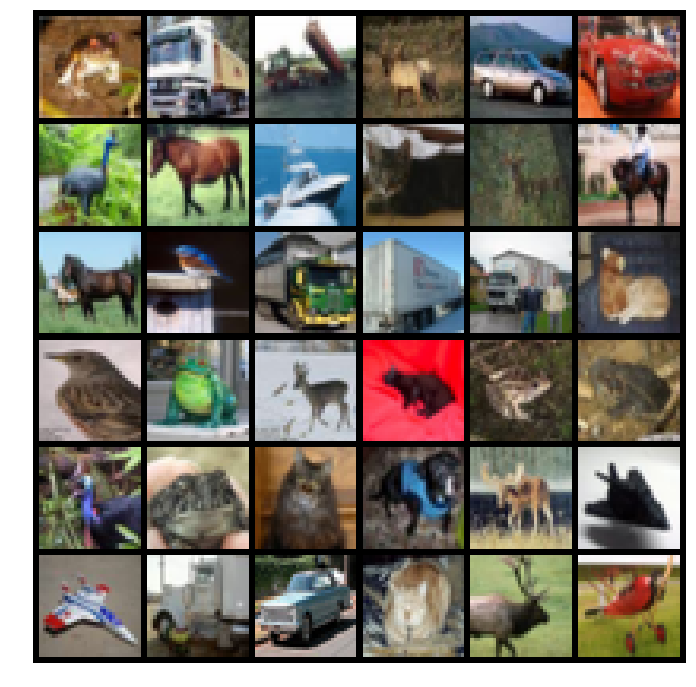

In [40]:
plot_batch(trainset, class_name = None, batch_size = 36, nrow = 6)

# Create cDCGAN Object

In [6]:
# Create the Discriminator
netD = Discriminator_32(len(cifar_classes), ngpu, nc = nc, ndf = 32).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Create the generator
netG = Generator_32(len(cifar_classes), ngpu, nz = nz, nc = nc, ngf = 32).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

kwargs = {
    'dataloader': trainloader, # cifar data dataloader
    'classes': cifar_classes, # cifar dataset classes
    'save_dir':'capstone-cifar-eval',
    'num_epochs': 0,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device,
    'nz': nz
}
    
cdcgan_cifar = cDCGAN(**kwargs)

capstone-cifar-eval directory exists.
capstone-cifar-eval/checkpoints directory exists.
capstone-cifar-eval/fake_images directory exists.


# Load latest epoch

In [7]:
cdcgan_cifar.load('capstone-model-cifar-output/checkpoints/checkpoint_e200.pth.tar', disp = True)


=> loading checkpoint: capstone-model-cifar-output/checkpoints/checkpoint_e200.pth.tar
=> loaded checkpoint: capstone-model-cifar-output/checkpoints/checkpoint_e200.pth.tar
Last epoch was 200


# Generate Fake Images

In [9]:
generate_fake_images(model = cdcgan_cifar, classes = cifar_classes, 
                     number_of_images = 5000, nz = nz,
                     device = device, 
                     save_dir = 'capstone-cifar-eval/fake_images',
                     save = True)


capstone-cifar-eval/fake_images/plane directory does not exist. Making capstone-cifar-eval/fake_images/plane
Generating 5000 images for plane
capstone-cifar-eval/fake_images/car directory does not exist. Making capstone-cifar-eval/fake_images/car
Generating 5000 images for car
capstone-cifar-eval/fake_images/bird directory does not exist. Making capstone-cifar-eval/fake_images/bird
Generating 5000 images for bird
capstone-cifar-eval/fake_images/cat directory does not exist. Making capstone-cifar-eval/fake_images/cat
Generating 5000 images for cat
capstone-cifar-eval/fake_images/deer directory does not exist. Making capstone-cifar-eval/fake_images/deer
Generating 5000 images for deer
capstone-cifar-eval/fake_images/dog directory does not exist. Making capstone-cifar-eval/fake_images/dog
Generating 5000 images for dog
capstone-cifar-eval/fake_images/frog directory does not exist. Making capstone-cifar-eval/fake_images/frog
Generating 5000 images for frog
capstone-cifar-eval/fake_images/h

# Plot Fake Images Generated for Each Class

In [41]:
# import dataset of generated images    
gen_dataset = dset.ImageFolder(
                    root='capstone-cifar-eval/fake_images',
                   transform=transforms.Compose([
                   transforms.Resize(image_size_cifar),
                   transforms.CenterCrop(image_size_cifar),
                   transforms.RandomHorizontalFlip(p=0.5),
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ]))

# Create dataloader
gen_dataloader = torch.utils.data.DataLoader(gen_dataset, batch_size = 128)


## Generated Images

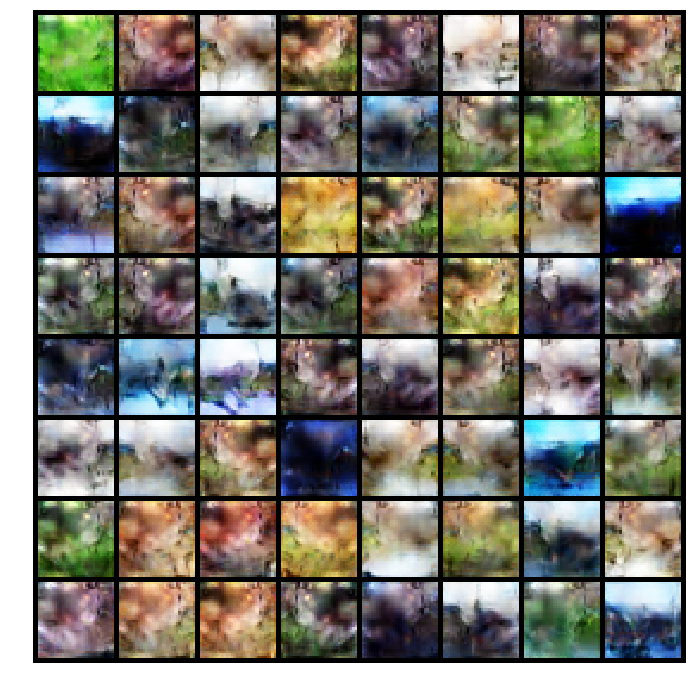

In [42]:
plot_batch(gen_dataset, class_name = None, batch_size = 64, nrow = 8)

# Compare Generated Images between Different Classes

Since the cDCGAN was trained with the CIFAR class name as the embedded conditional, we can observe the effect of the conditional information on the generated output by comparing the fake images generated when a fixed noise input is used.

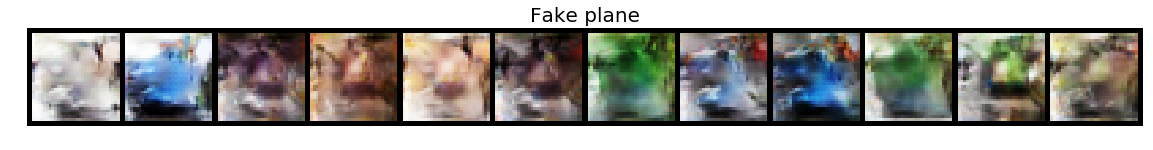

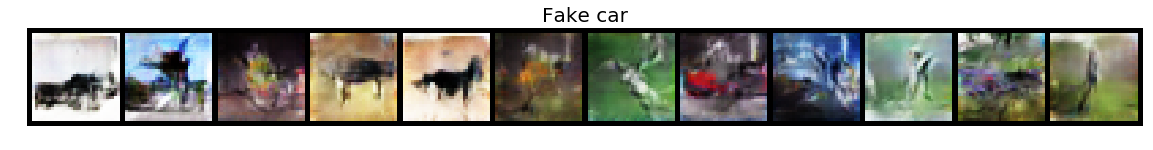

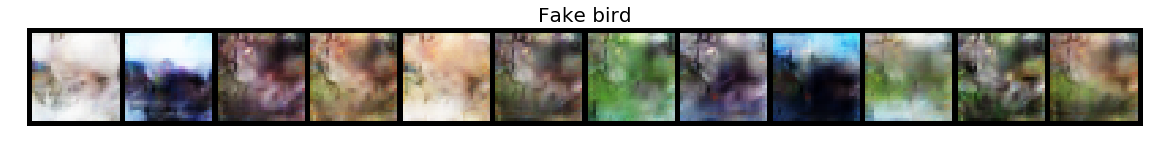

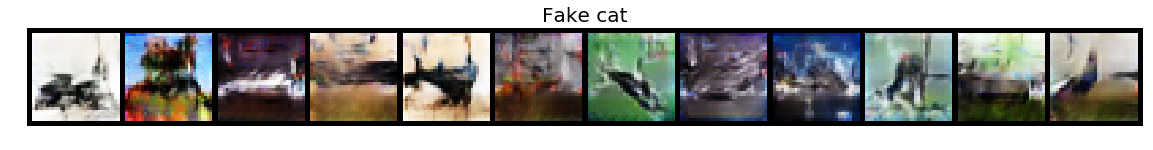

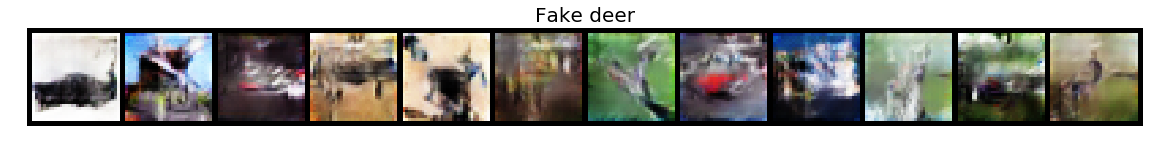

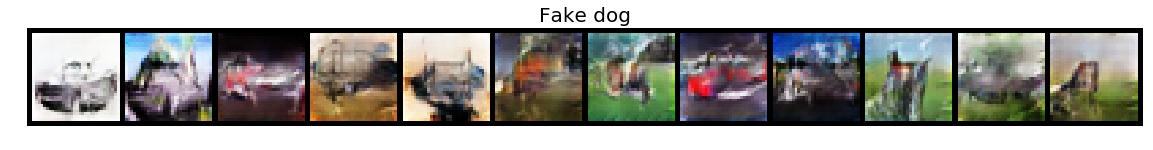

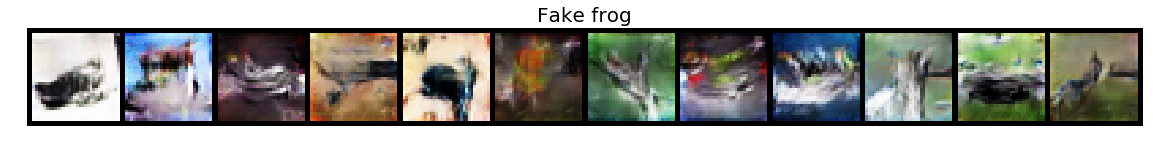

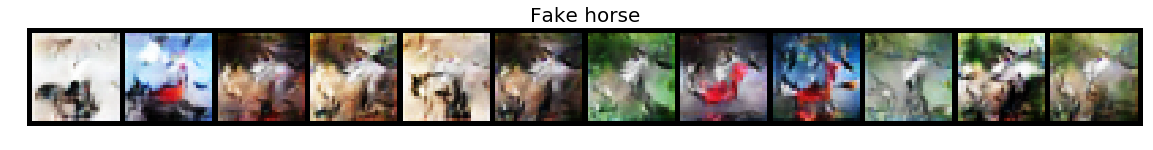

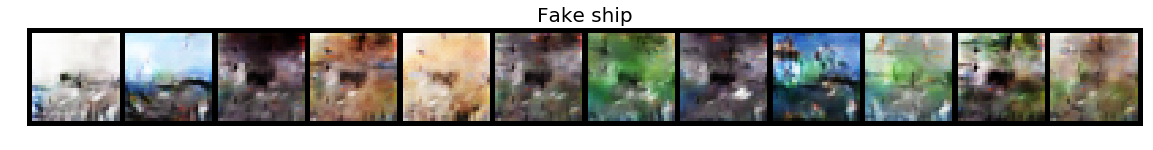

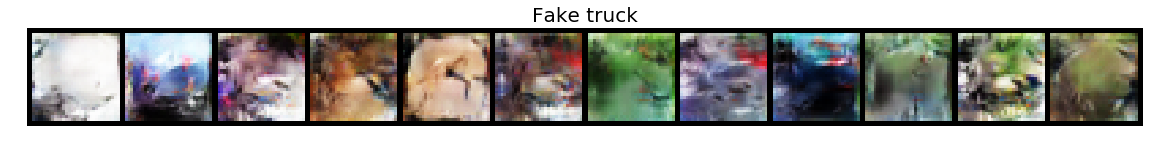

In [17]:
plot_gen_images(cifar_classes, cdcgan_cifar, nz = nz, device = device, no_of_images = 12)

# Plot Generated Images at Different Training Epochs

The model weights at each training epoch were saved as checkpoints. As such, the progression of the image generation process for the different classes can be observed.

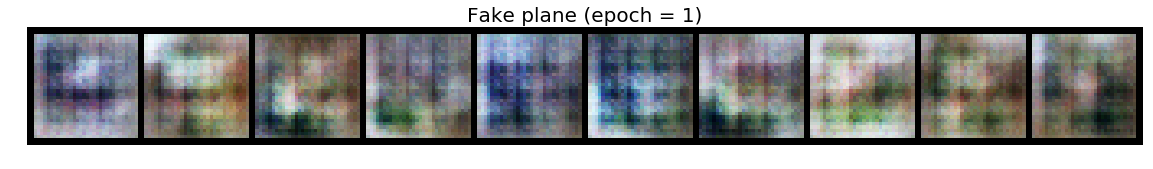

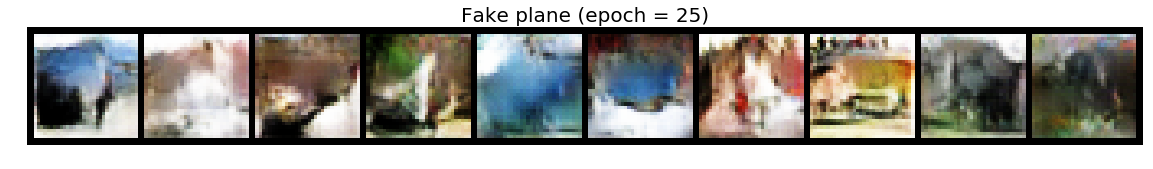

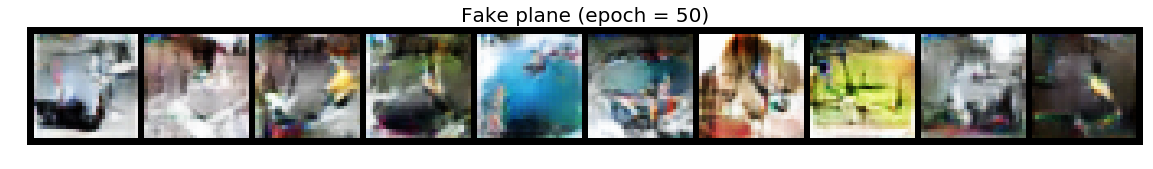

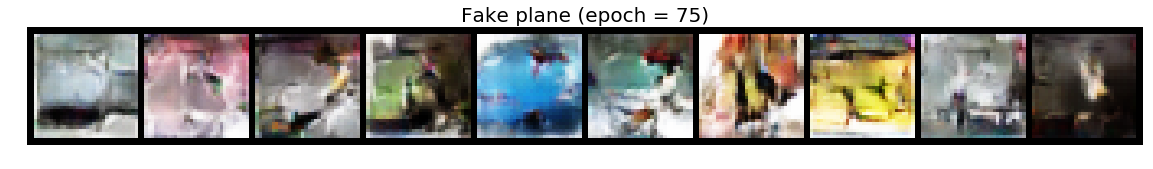

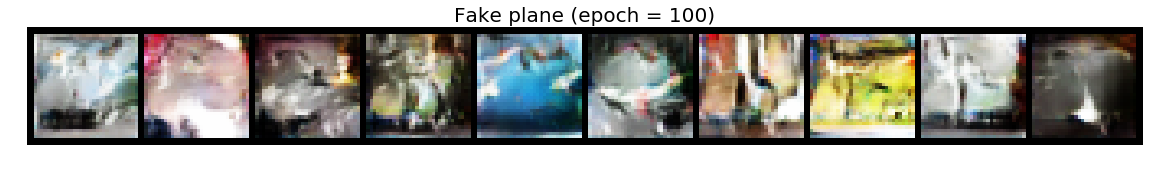

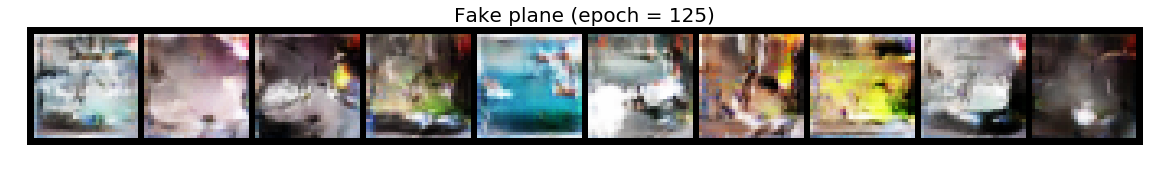

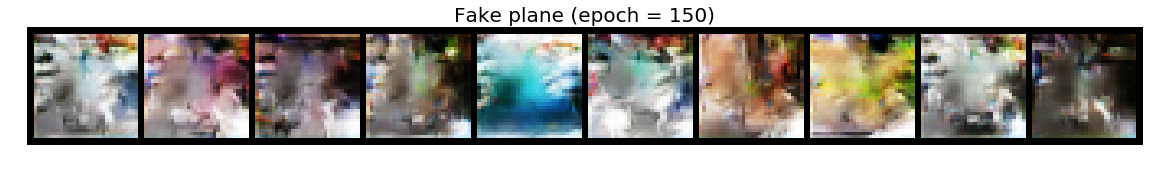

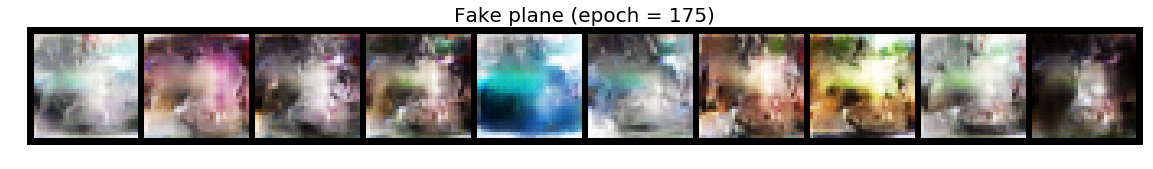

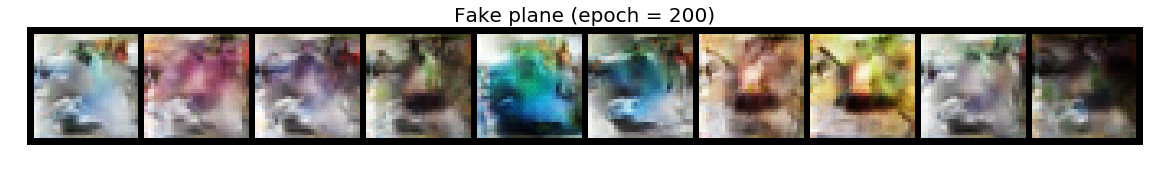

In [30]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'plane', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

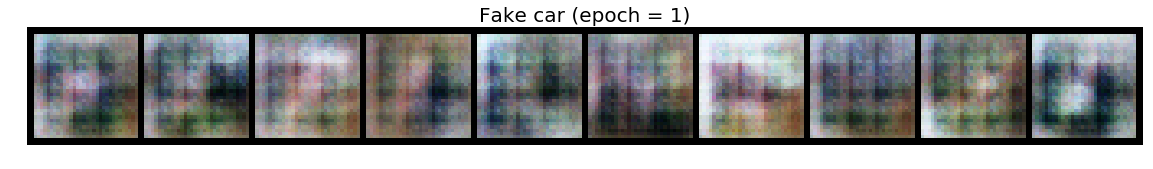

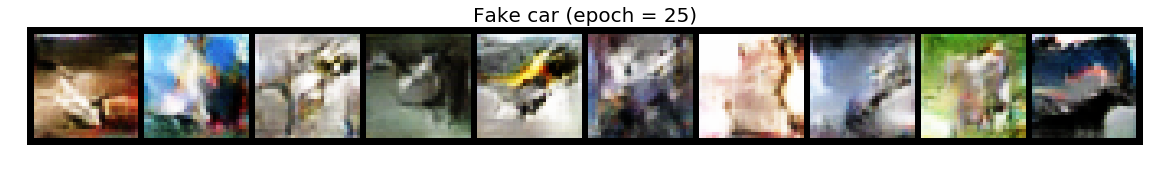

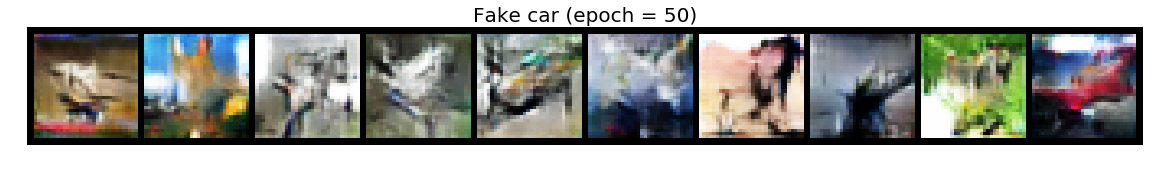

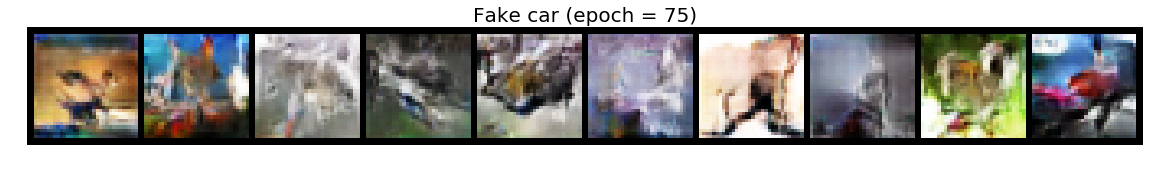

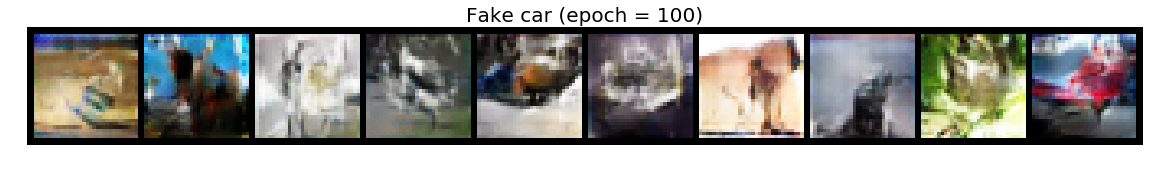

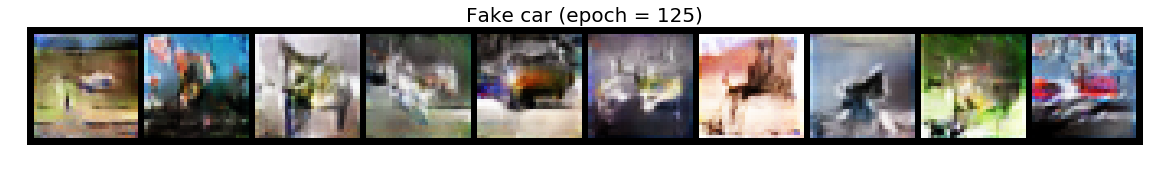

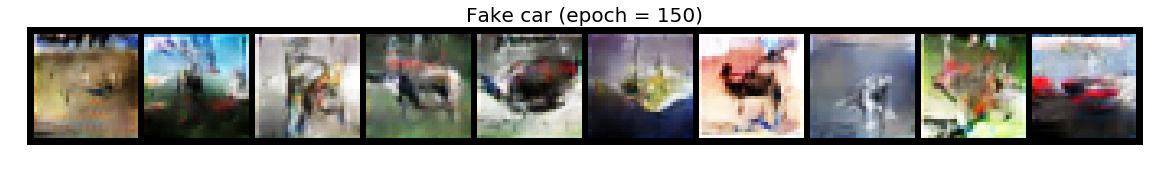

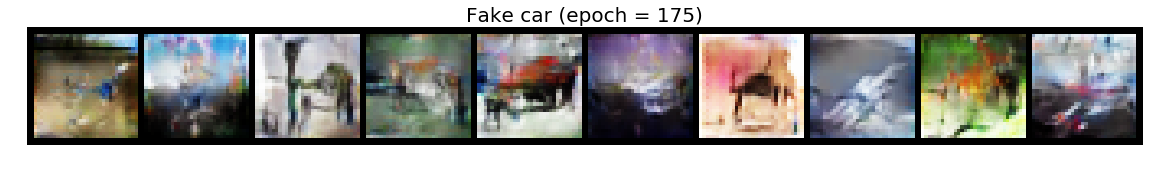

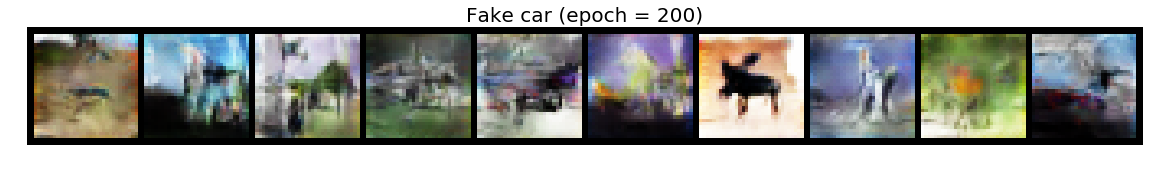

In [23]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'car', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

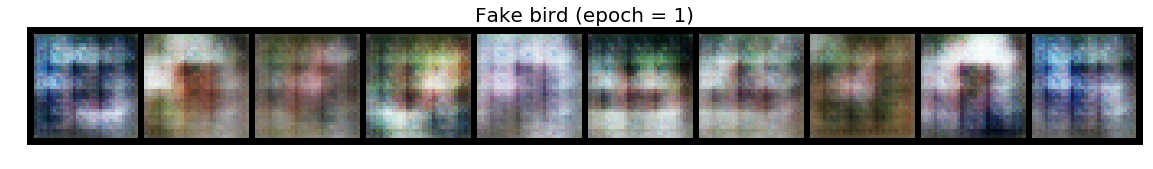

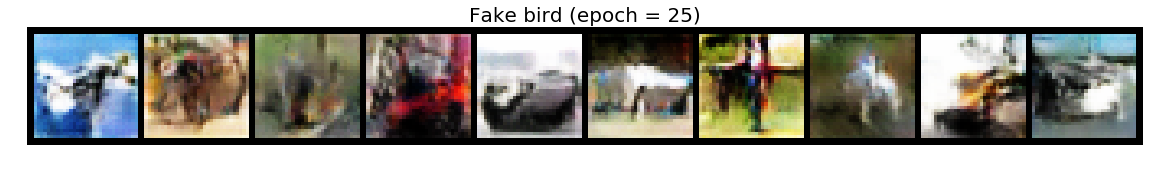

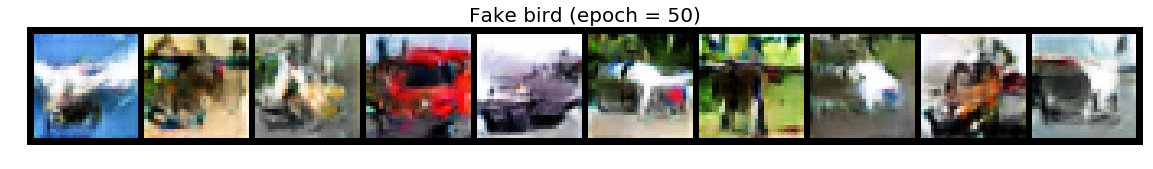

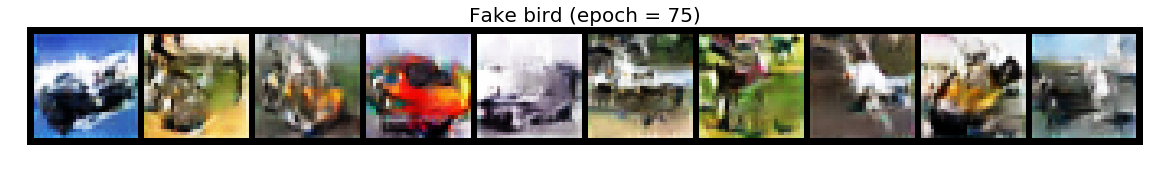

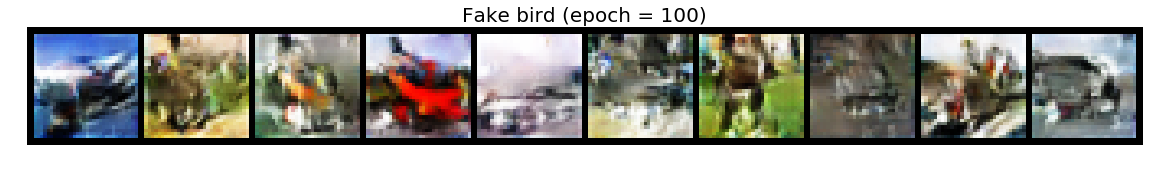

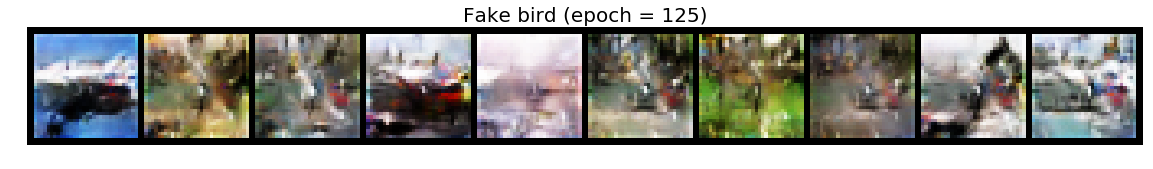

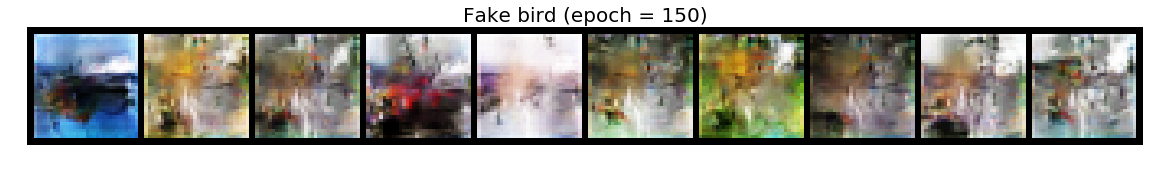

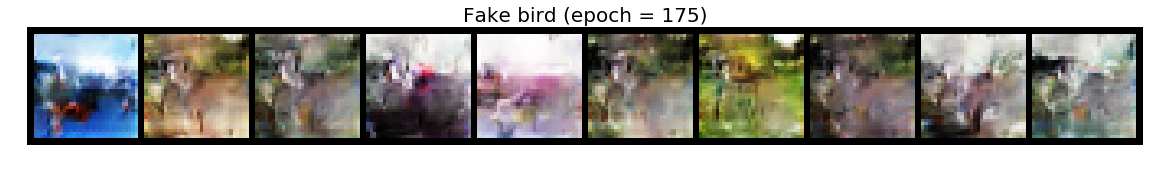

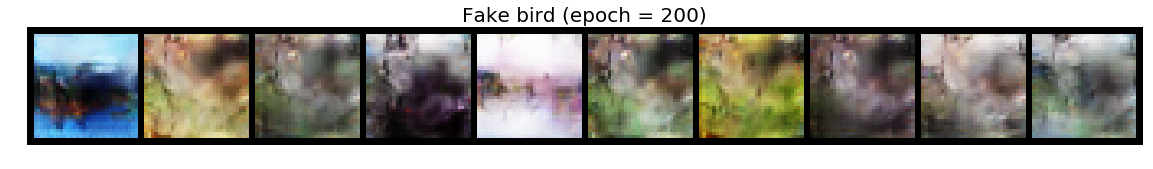

In [31]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'bird', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

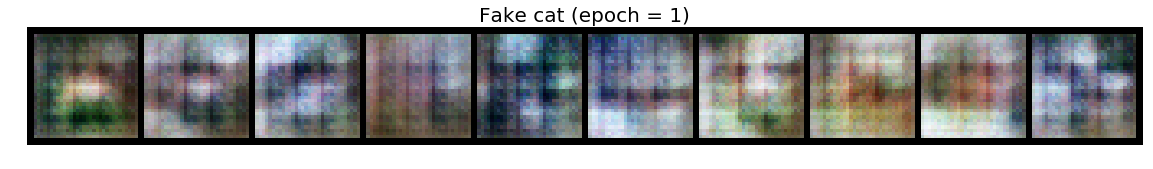

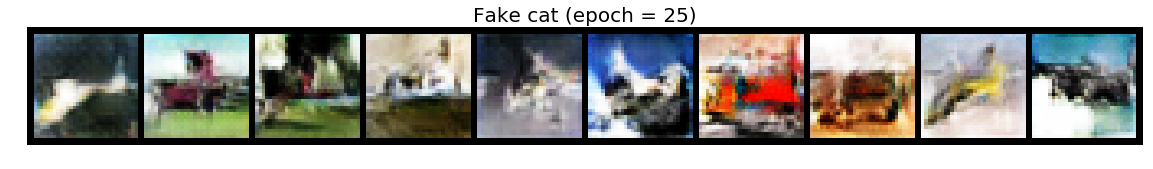

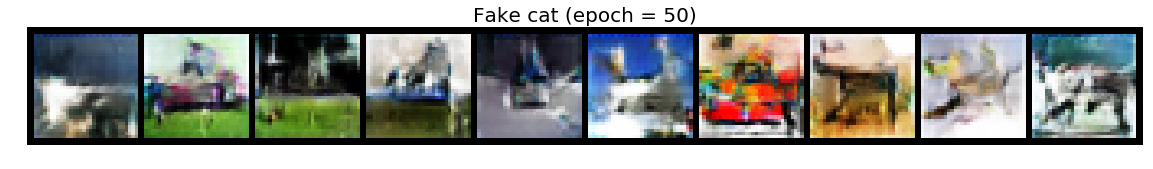

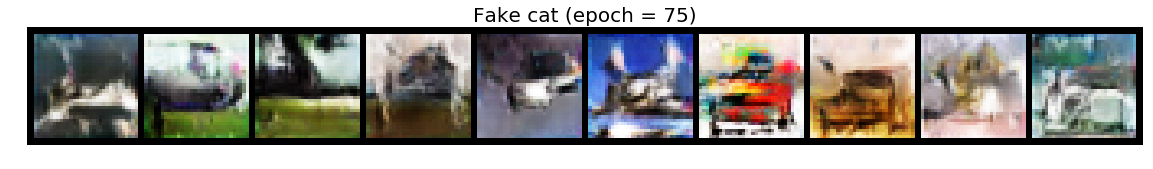

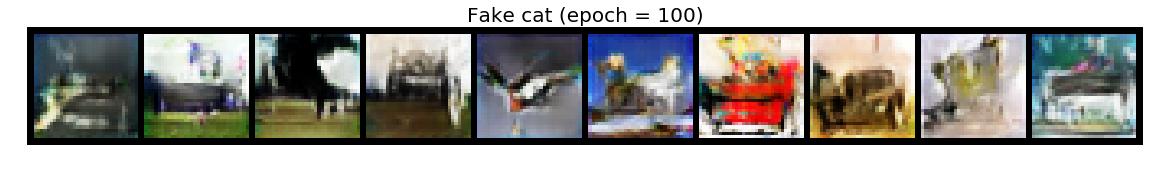

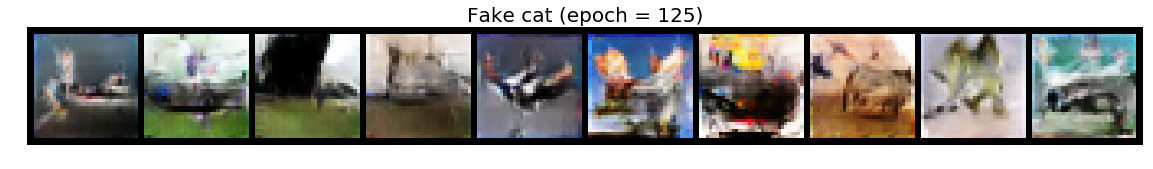

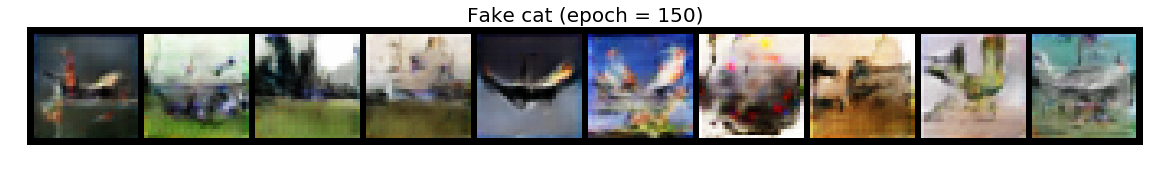

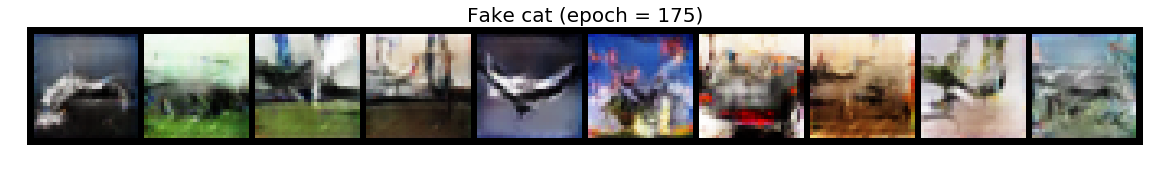

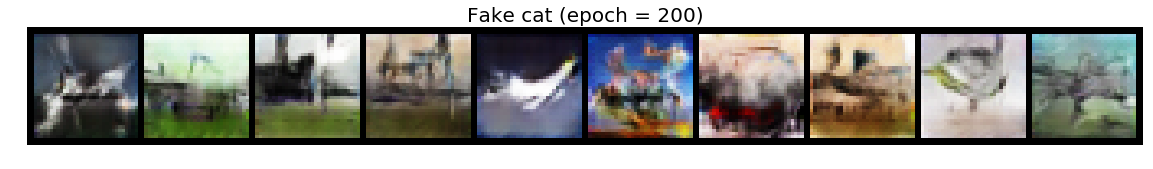

In [32]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'cat', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

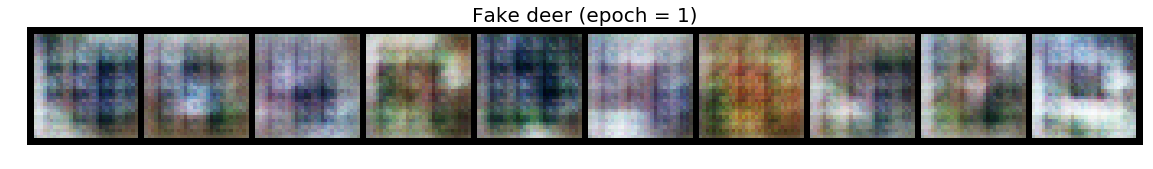

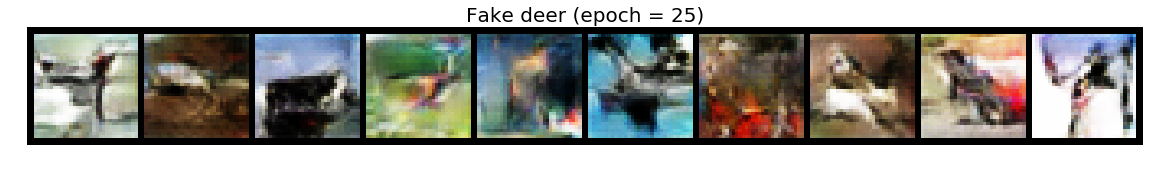

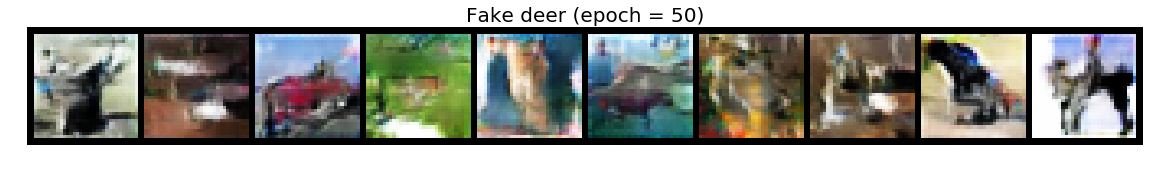

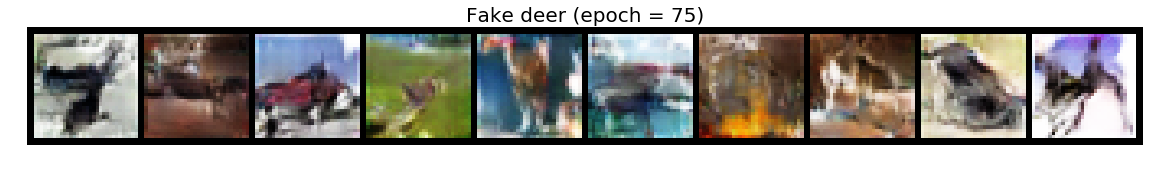

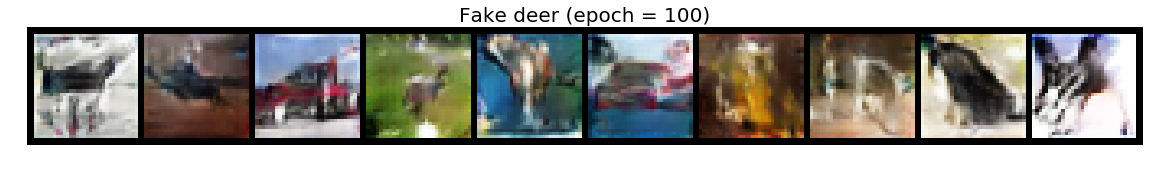

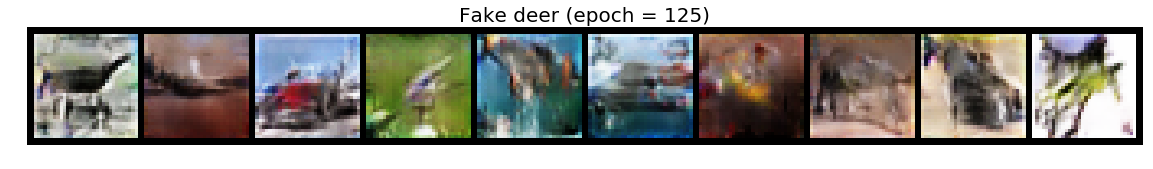

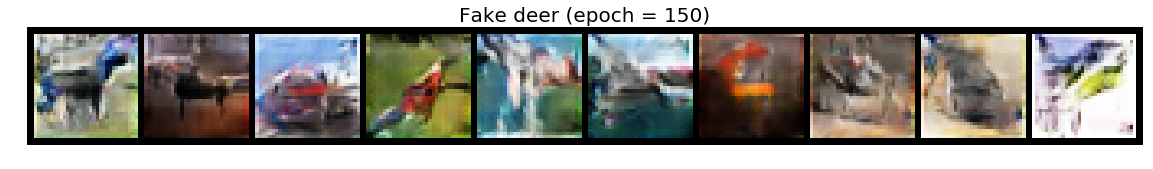

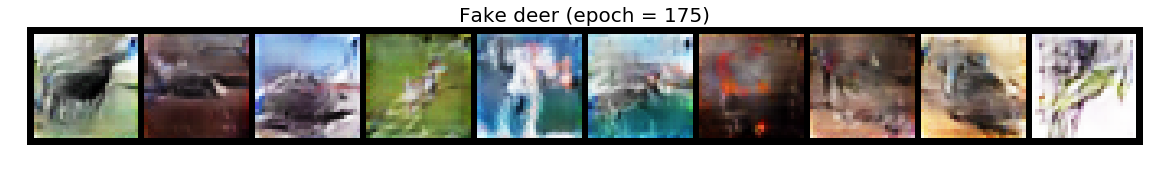

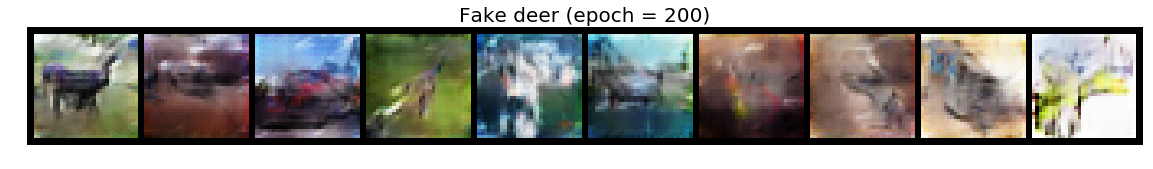

In [33]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'deer', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

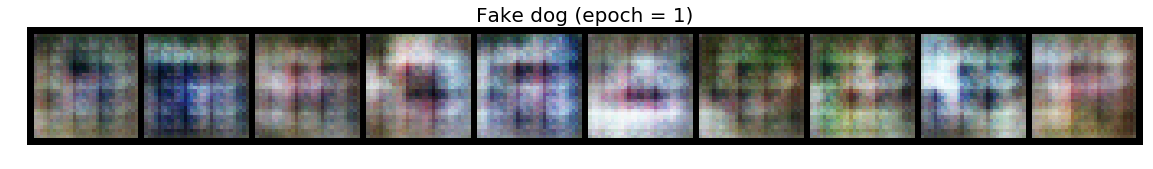

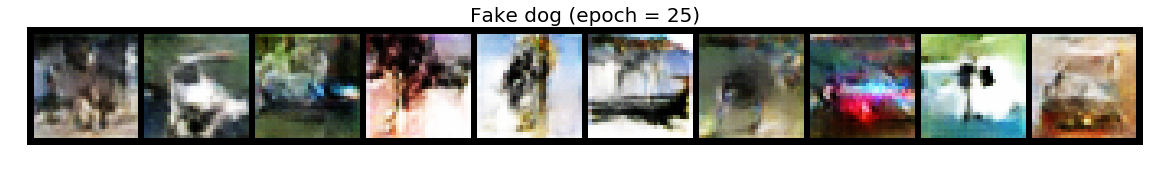

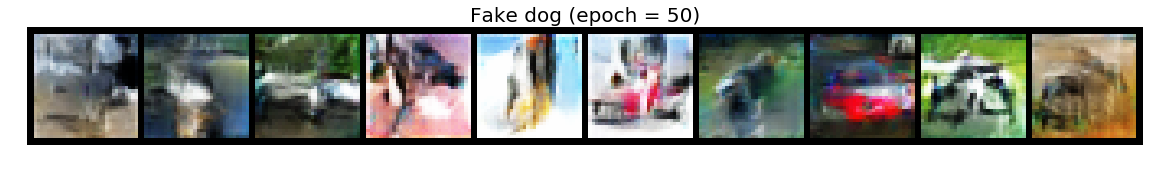

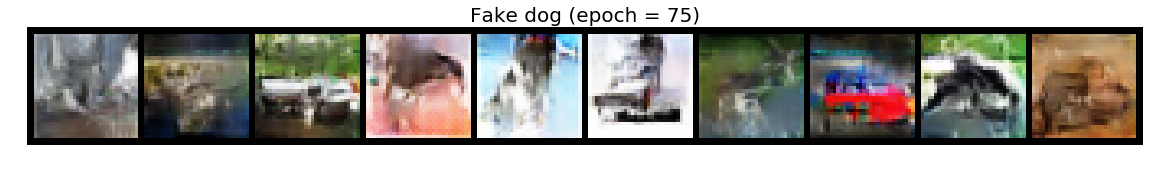

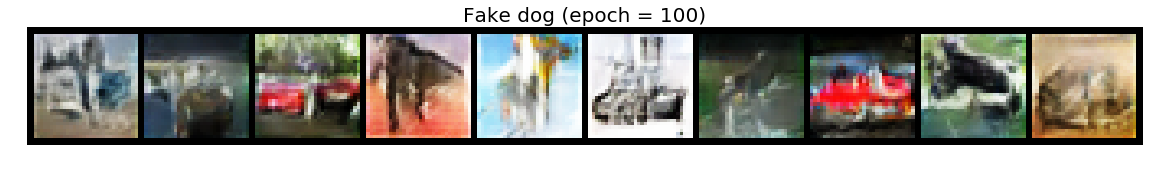

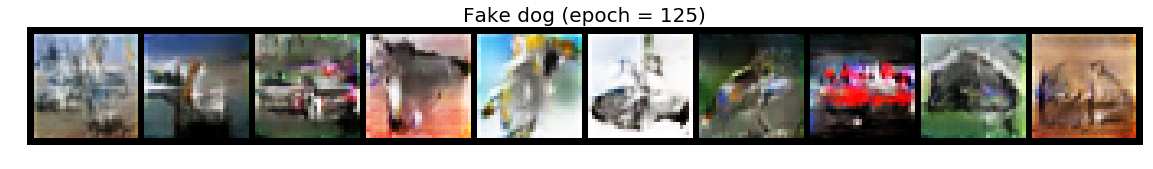

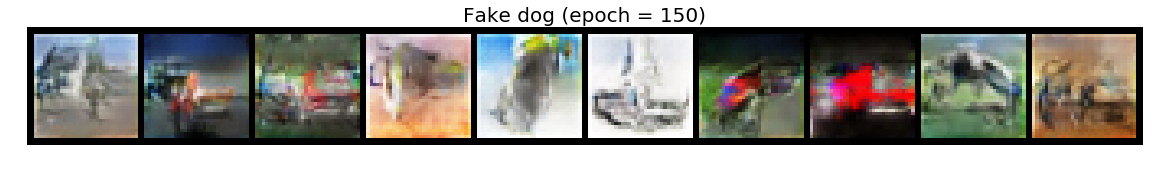

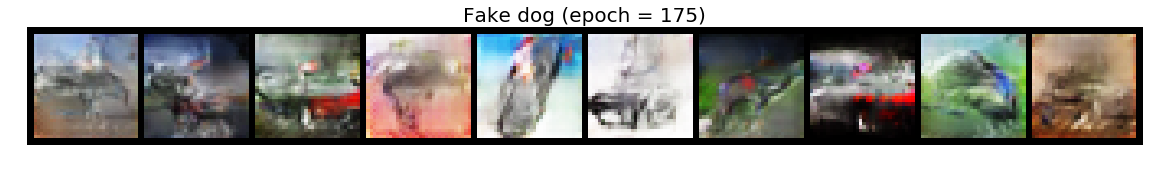

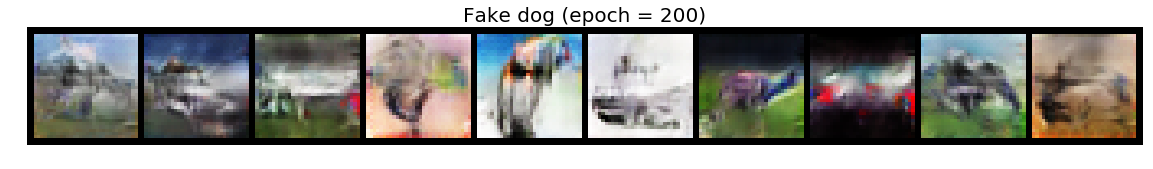

In [34]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'dog', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

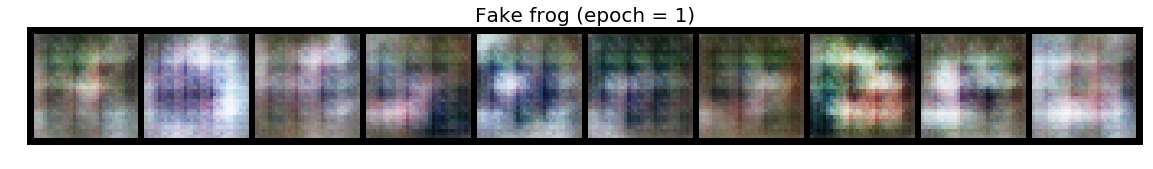

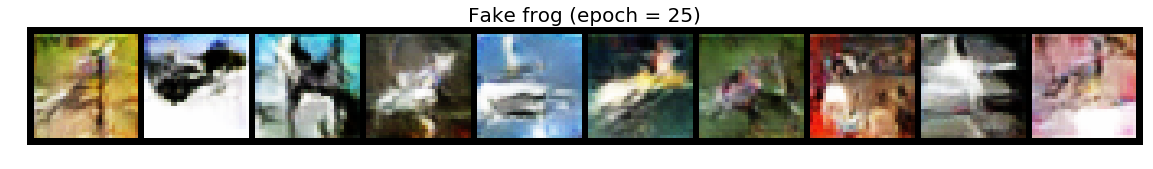

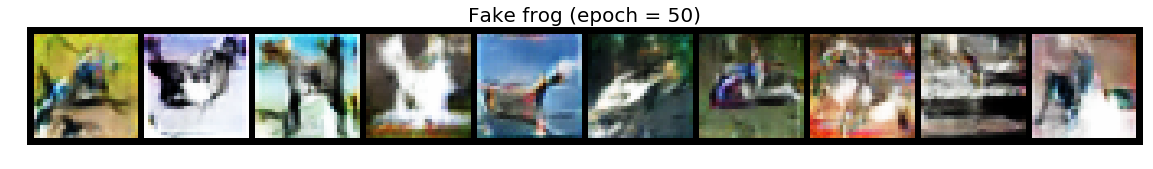

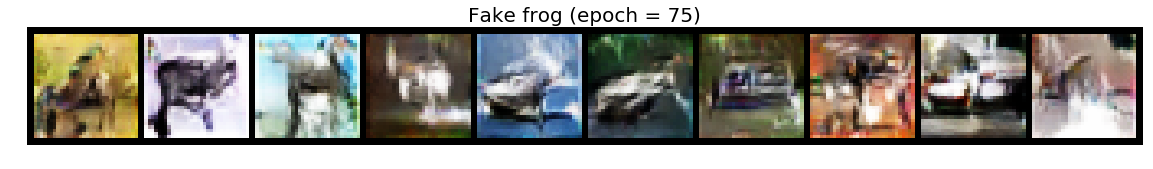

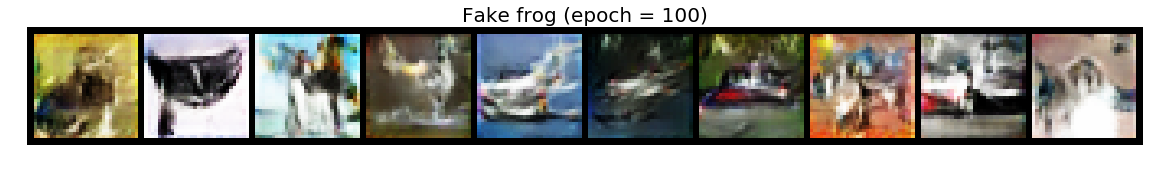

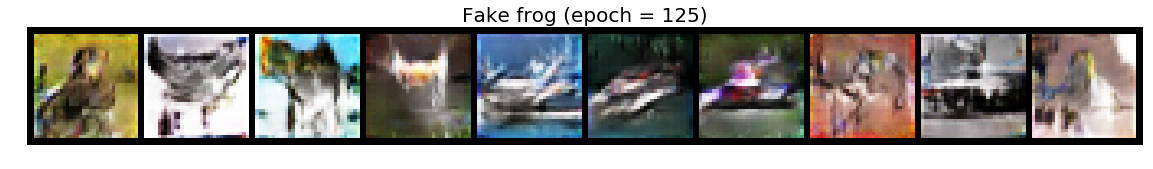

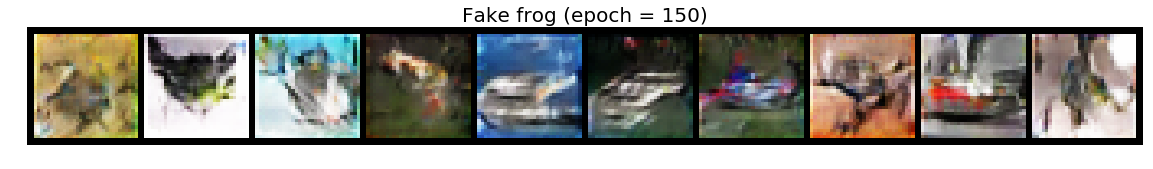

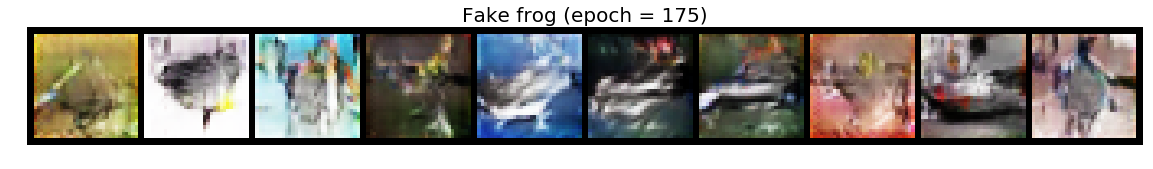

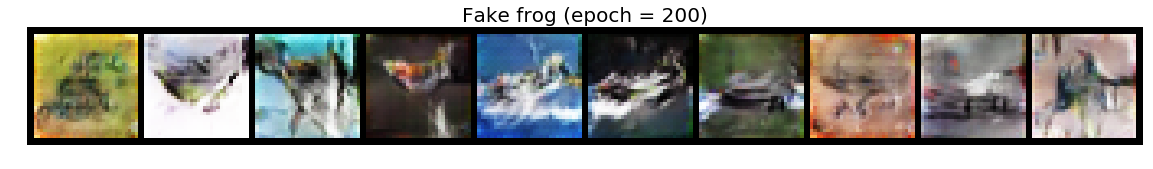

In [35]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'frog', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

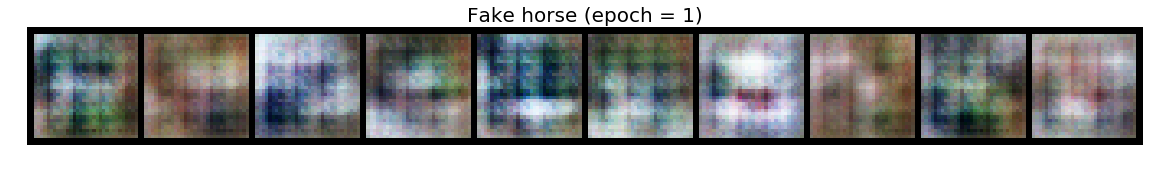

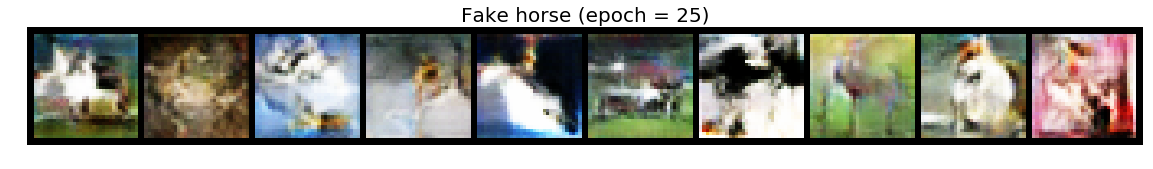

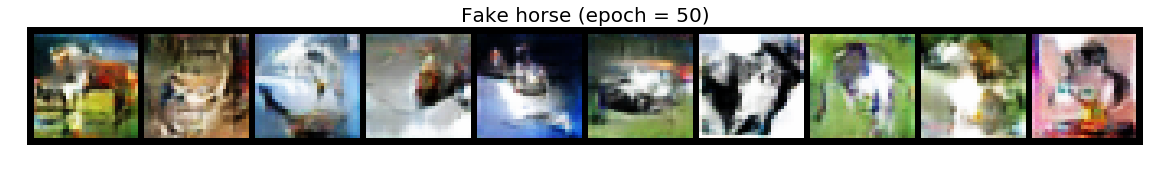

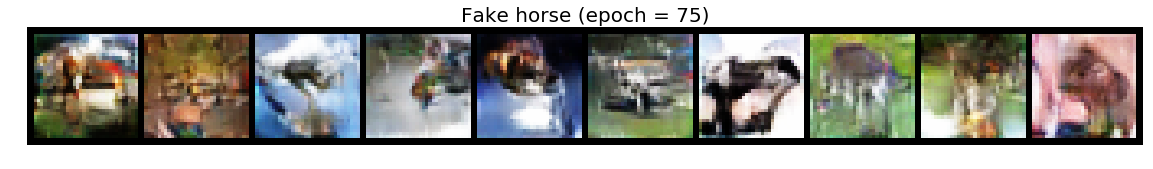

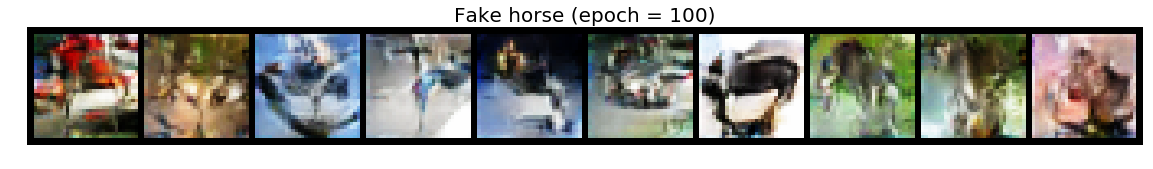

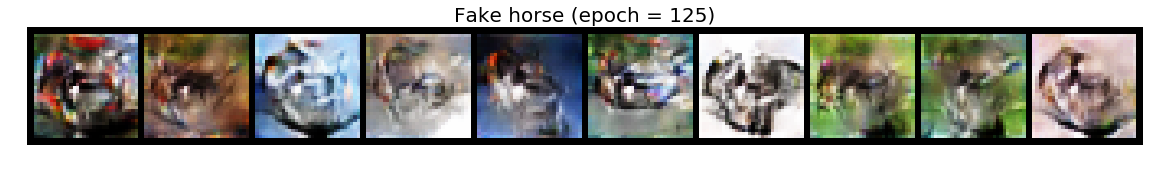

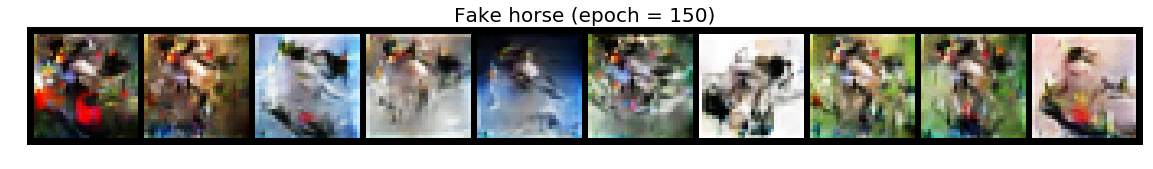

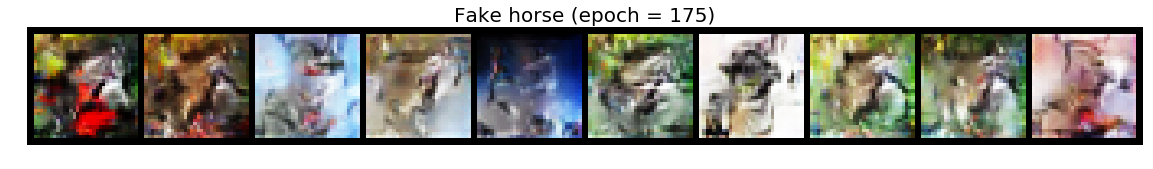

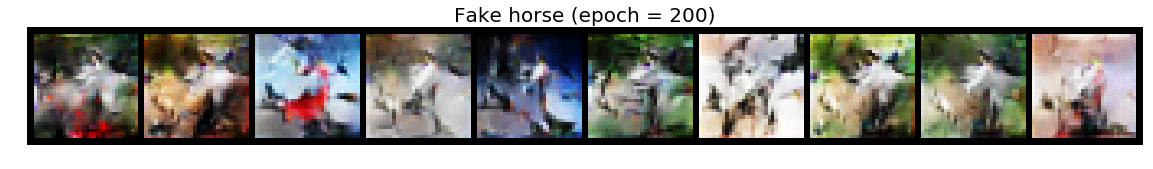

In [36]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'horse', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

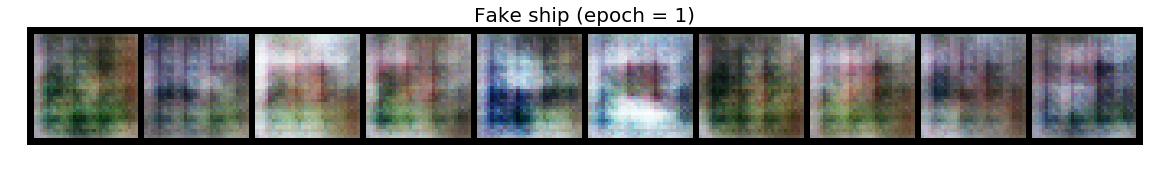

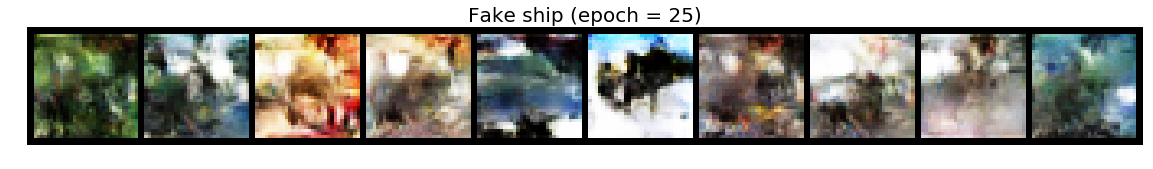

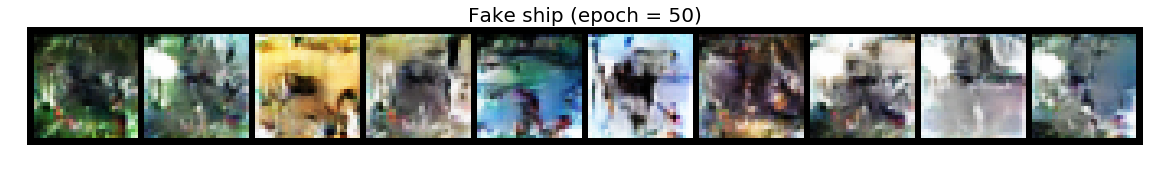

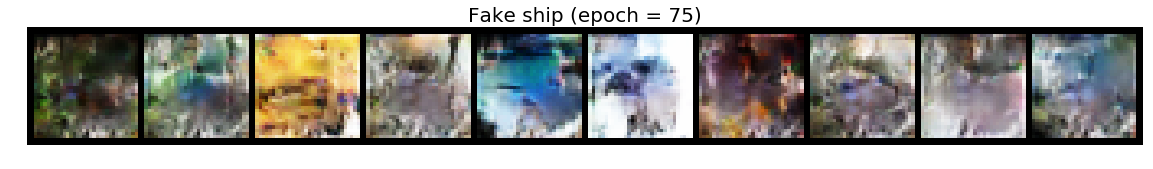

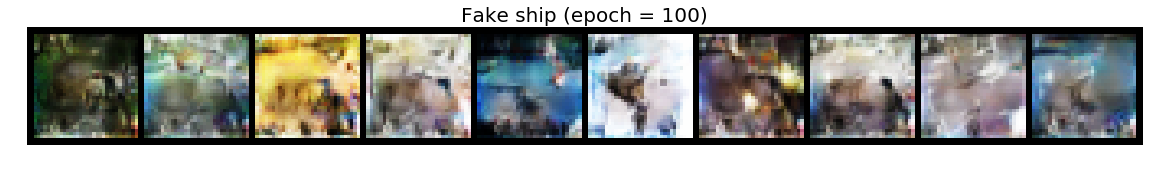

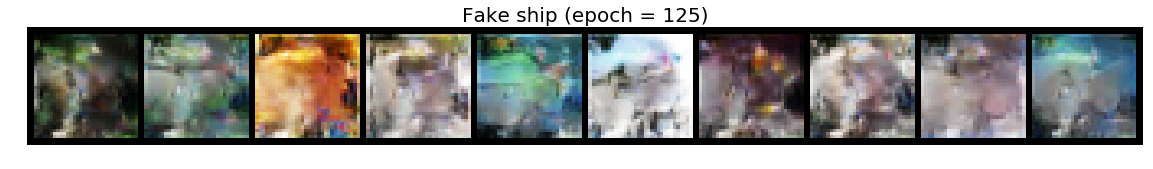

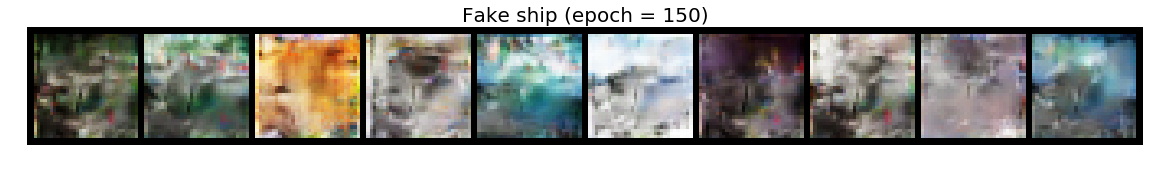

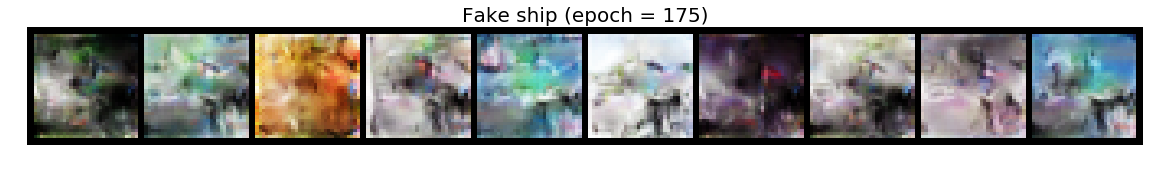

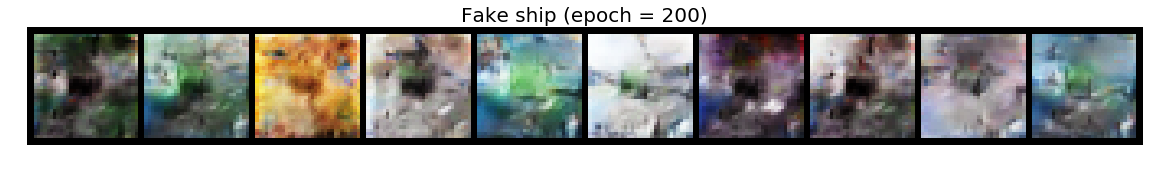

In [37]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'ship', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)

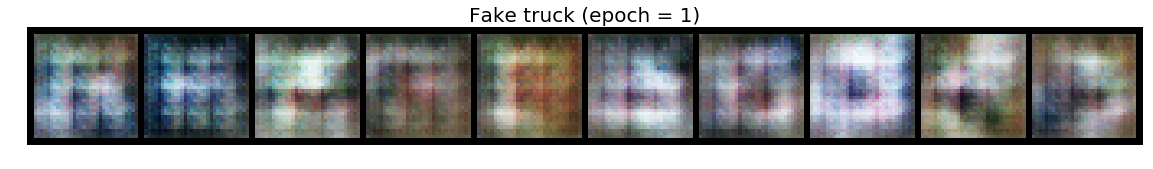

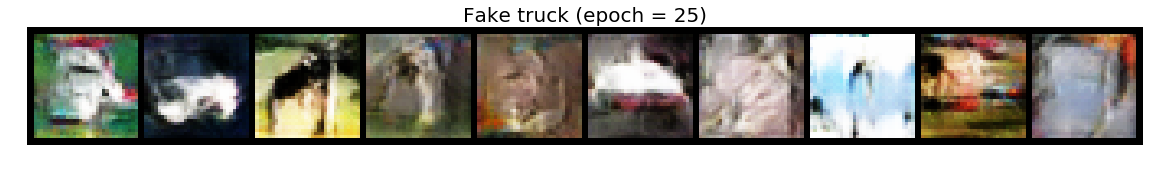

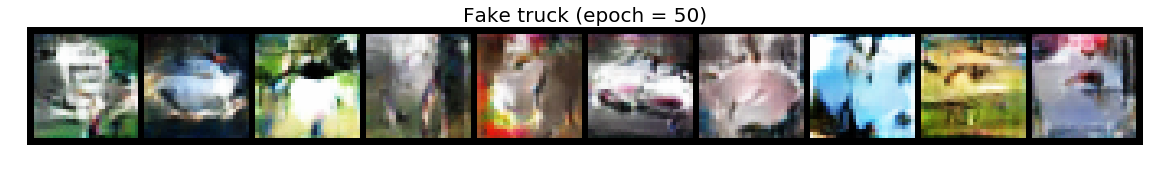

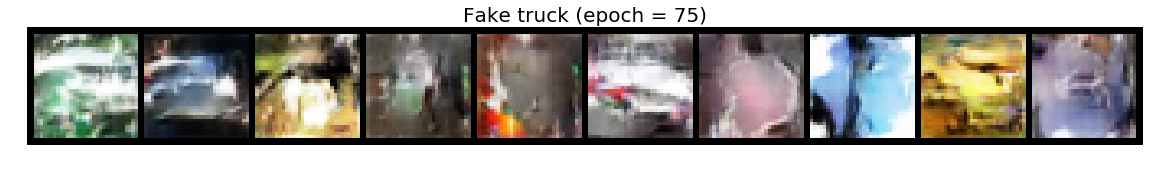

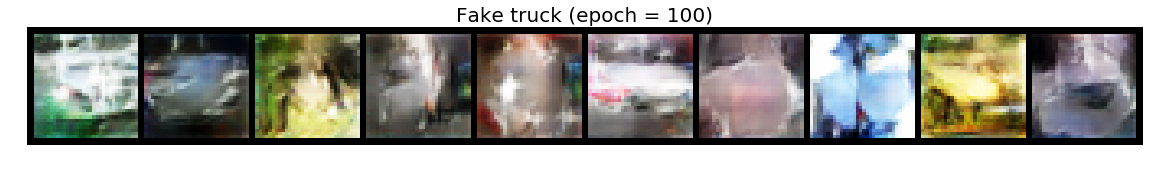

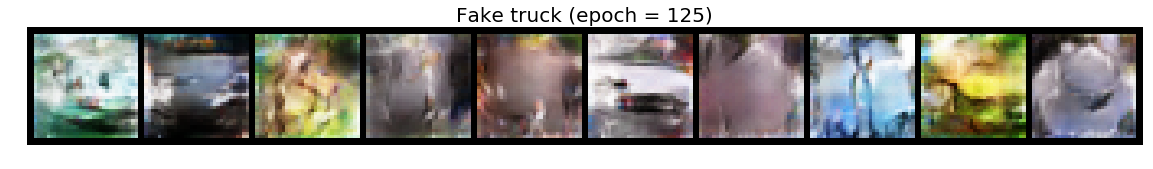

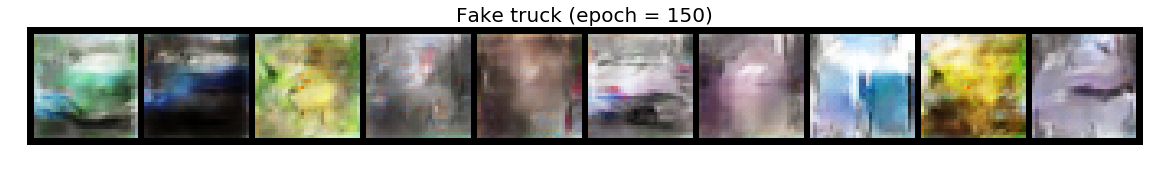

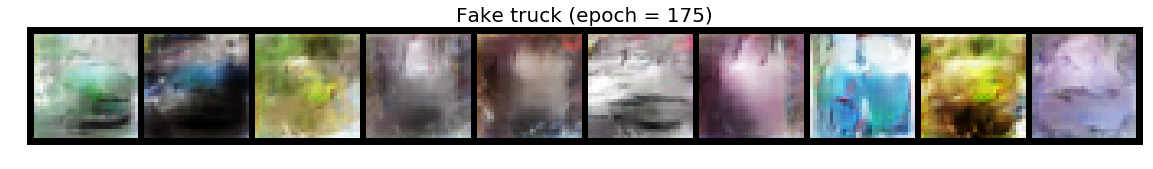

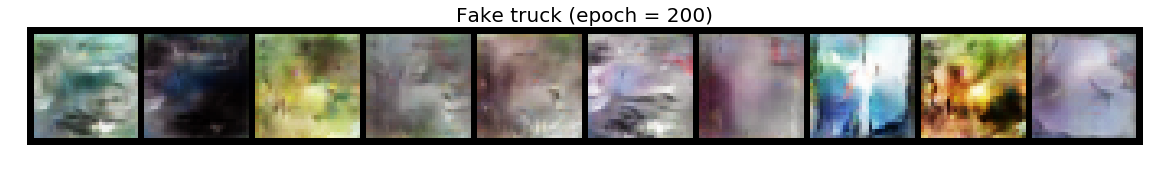

In [38]:
plot_progression(model = cdcgan_cifar, classes = cifar_classes, class_name = 'truck', 
                 checkpoint_dir = 'capstone-model-cifar-output/checkpoints',
                 epoch_list = [1,25,50,75,100,125,150,175,200], no_of_images = 10,
                 nz = nz, device = device)